Epoch 1/100, Loss: 0.092539
Epoch 2/100, Loss: 0.035633
Epoch 3/100, Loss: 0.007324
Epoch 4/100, Loss: 0.002378
Epoch 5/100, Loss: 0.001722
Epoch 6/100, Loss: 0.000506
Epoch 7/100, Loss: 0.000219
Epoch 8/100, Loss: 0.000199
Epoch 9/100, Loss: 0.000187
Epoch 10/100, Loss: 0.000177
Epoch 11/100, Loss: 0.000167
Epoch 12/100, Loss: 0.000154
Epoch 13/100, Loss: 0.000138
Epoch 14/100, Loss: 0.000119
Epoch 15/100, Loss: 0.000091
Epoch 16/100, Loss: 0.000062
Epoch 17/100, Loss: 0.000042
Epoch 18/100, Loss: 0.000036
Epoch 19/100, Loss: 0.000034
Epoch 20/100, Loss: 0.000032
Epoch 21/100, Loss: 0.000032
Epoch 22/100, Loss: 0.000030
Epoch 23/100, Loss: 0.000030
Epoch 24/100, Loss: 0.000029
Epoch 25/100, Loss: 0.000030
Epoch 26/100, Loss: 0.000028
Epoch 27/100, Loss: 0.000028
Epoch 28/100, Loss: 0.000028
Epoch 29/100, Loss: 0.000027
Epoch 30/100, Loss: 0.000026
Epoch 31/100, Loss: 0.000027
Epoch 32/100, Loss: 0.000027
Epoch 33/100, Loss: 0.000025
Epoch 34/100, Loss: 0.000026
Epoch 35/100, Loss: 0.0

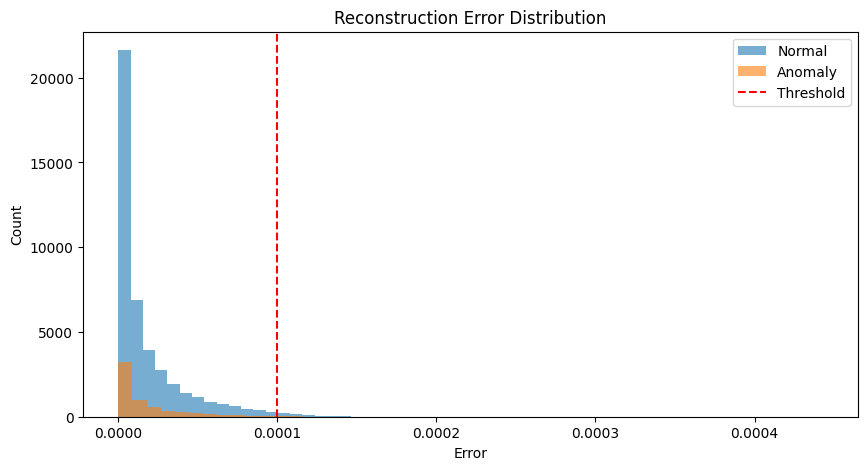

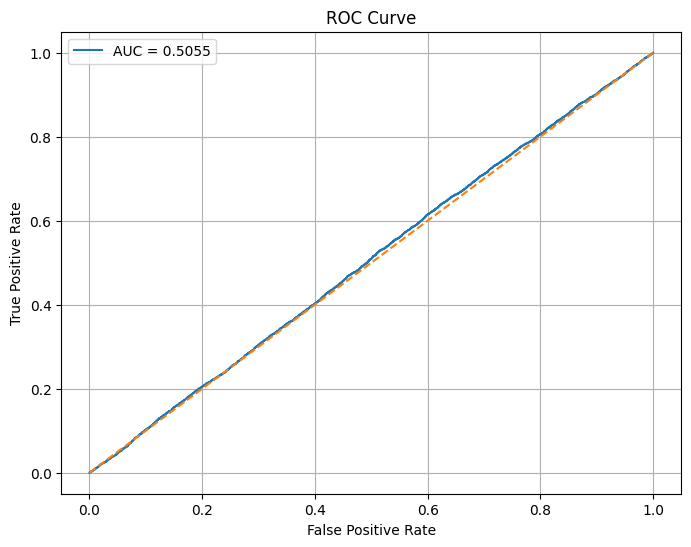

In [ ]:
# Autoencoder-based Anomaly Detection for Smart Grid Data (trained on normal data only)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Load dataset
df = pd.read_csv("/content/smart_grid_dataset.csv")

# Drop non-feature columns
target_cols = ["Overload Condition", "Transformer Fault"]
df_targets = df[target_cols].copy()
df_features = df.drop(columns=["Timestamp"] + target_cols)

# Filter normal data only (no overload, no fault)
normal_data = df[(df["Overload Condition"] == 0) & (df["Transformer Fault"] == 0)]
normal_features = normal_data.drop(columns=["Timestamp"] + target_cols)

# Scale the data
scaler = MinMaxScaler()
normal_scaled = scaler.fit_transform(normal_features)
full_scaled = scaler.transform(df_features)

normal_tensor = torch.tensor(normal_scaled, dtype=torch.float32)
full_tensor = torch.tensor(full_scaled, dtype=torch.float32)

# DataLoader
batch_size = 128
dataset = TensorDataset(normal_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# Initialize model
input_dim = normal_tensor.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Lower LR for stability

# Train Autoencoder
epochs = 100  # Increased epochs
model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for batch in dataloader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dataloader):.6f}")

# Evaluate model
model.eval()
with torch.no_grad():
    reconstructed = model(full_tensor)
    reconstruction_error = torch.mean((full_tensor - reconstructed) ** 2, dim=1).numpy()

# Determine threshold using F1 score optimization
y_true = (df_targets["Overload Condition"] | df_targets["Transformer Fault"]).values
best_f1 = 0
best_threshold = 0

for threshold in np.linspace(0.0001, 0.05, 100):
    y_pred = (reconstruction_error > threshold).astype(int)
    f1 = f1_score(y_true, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print("\nBest Threshold:", best_threshold)
print("F1 Score:", best_f1)

# Final predictions
y_pred_final = (reconstruction_error > best_threshold).astype(int)
precision = precision_score(y_true, y_pred_final)
recall = recall_score(y_true, y_pred_final)
f1 = f1_score(y_true, y_pred_final)

print("\nEvaluation Results")
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4))

# Show top contributing features for anomalies
errors = np.abs(full_scaled - reconstructed.numpy())
mean_errors = np.mean(errors[y_pred_final == 1], axis=0)
feature_contributions = sorted(zip(df_features.columns, mean_errors), key=lambda x: x[1], reverse=True)

print("\nTop Contributing Features to Anomaly:")
for feature, diff in feature_contributions[:5]:
    print(f"{feature}: Diff = {diff:.4f}")

# Plot reconstruction error distribution
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_error[y_true == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(reconstruction_error[y_true == 1], bins=50, alpha=0.6, label='Anomaly')
plt.axvline(best_threshold, color='red', linestyle='--', label='Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Count')
plt.legend()
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, reconstruction_error)
auc = roc_auc_score(y_true, reconstruction_error)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

